<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#графики-для-анализа" data-toc-modified-id="графики-для-анализа-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>графики для анализа</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#наиболее-загружанные-часы" data-toc-modified-id="наиболее-загружанные-часы-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>наиболее загружанные часы</a></span></li><li><span><a href="#вывод-после-анализа" data-toc-modified-id="вывод-после-анализа-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>вывод после анализа</a></span></li><li><span><a href="#Добаление-фичей" data-toc-modified-id="Добаление-фичей-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Добаление фичей</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

## Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'],index_col='datetime')
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


- **Функция для начального анализа**

In [3]:
def df_info(df):
    print(df.shape)
    print(df.info())
    
    if df.isna().values.any():
        display(pd.DataFrame(df.isna().mean().to_frame(name='gaps')).style.format({'gaps' : '{:.2%}'}))
    else: print('No gaps')
        
    
    print('есть ли дупликаты',df.duplicated().values.any())
    
    display(df.head(10))
df_info(df)

(4416, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
No gaps
есть ли дупликаты True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

### графики для анализа 

<AxesSubplot:xlabel='datetime'>

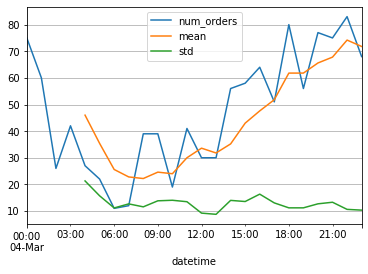

In [4]:
df_month = df['2018-03-04']
df_month['mean'] = df_month['num_orders'].rolling(5).mean()
df_month['std'] = df_month['num_orders'].rolling(5).std()
df_month.plot(grid=True)

<AxesSubplot:xlabel='datetime'>

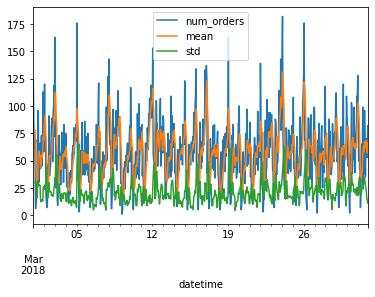

In [5]:
df_month = df['2018-03-01' : '2018-03-31'] 
df_month['mean'] = df_month['num_orders'].rolling(5).mean()
df_month['std'] = df_month['num_orders'].rolling(5).std()
df_month.plot()

<AxesSubplot:xlabel='datetime'>

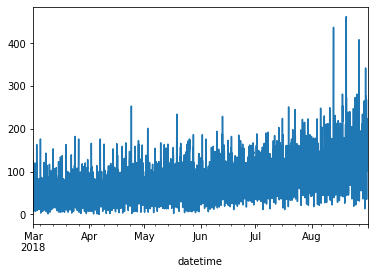

In [6]:
df_month = df['2018-03-01' : '2019-03-01'] 
#df_month['mean'] = df_month['num_orders'].rolling(5).mean()
#df_month['std'] = df_month['num_orders'].rolling(5).std()
df_month['num_orders'].plot()

### Тренды и сезонность

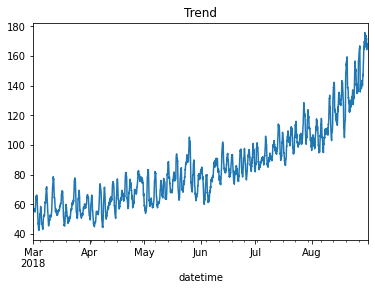

In [7]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(title='Trend');

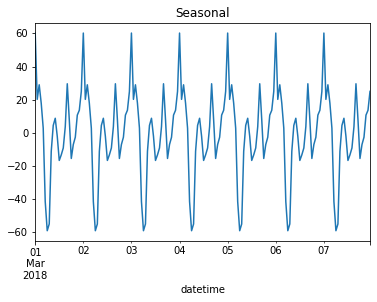

In [8]:
decomposed.seasonal.head(24*7).plot(title='Seasonal');


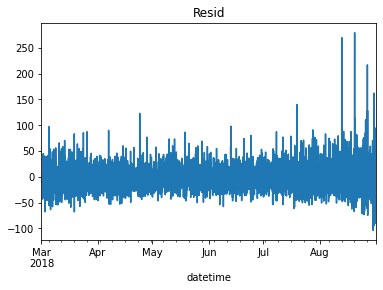

In [9]:
decomposed.resid.plot(title='Resid');

### наиболее загружанные часы 

In [10]:
df_month.loc[df_month['num_orders'] >= 60].index.hour.value_counts().sort_index()


0     182
1     158
2     143
3     152
4     112
5      50
6      18
7      11
8     133
9     140
10    145
11    144
12     90
13    116
14    123
15    156
16    170
17    134
18    104
19    138
20    149
21    161
22    172
23    172
Name: datetime, dtype: int64

In [11]:
count = pd.DataFrame(df.loc[df['num_orders'] >= 60].index.hour.value_counts().sort_index())
count.loc[count['datetime'] >= 50]

,datetime
0,182
1,158
2,143
3,152
4,112
5,50
8,133
9,140
10,145
11,144


### вывод после анализа

- после анализа видно, что есть опреленные часы, когда заказы в пиковом количестве

- так же присудствует сезонность по часам , что видно из графика

- можно посмотреть во сколько было максимальное количество вызовов

### Добаление фичей

In [12]:
df['day_lag'] = df['num_orders'].shift(1)
df['two_day_lag'] = df['num_orders'].shift(2)
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['rolling_mean'] = df.num_orders.rolling(2).mean()
df.fillna(0, inplace=True)
df.head()

,num_orders,day_lag,two_day_lag,dayofweek,hour,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0.0,0.0,3,0,0.0
2018-03-01 01:00:00,85,124.0,0.0,3,1,104.5
2018-03-01 02:00:00,71,85.0,124.0,3,2,78.0
2018-03-01 03:00:00,66,71.0,85.0,3,3,68.5
2018-03-01 04:00:00,43,66.0,71.0,3,4,54.5


In [13]:
df.describe()

,num_orders,day_lag,two_day_lag,dayofweek,hour,rolling_mean
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4416.000000
mean,84.422781,84.376359,84.325861,3.005435,11.50000,84.385530
std,45.023853,45.005183,44.974703,1.990684,6.92297,40.574812
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,54.000000,54.000000,54.000000,1.000000,5.75000,57.375000
50%,78.000000,78.000000,78.000000,3.000000,11.50000,79.000000
75%,107.000000,107.000000,107.000000,5.000000,17.25000,105.500000
max,462.000000,462.000000,462.000000,6.000000,23.00000,367.000000


In [14]:
cat_col = ['dayofweek','hour']
num_col = ['day_lag', 'rolling_mean', 'two_day_lag']

In [15]:
X = df.drop(columns='num_orders')
y = df['num_orders']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3974, 5), (442, 5), (3974,), (442,))

In [18]:
df

,num_orders,day_lag,two_day_lag,dayofweek,hour,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0.0,0.0,3,0,0.0
2018-03-01 01:00:00,85,124.0,0.0,3,1,104.5
2018-03-01 02:00:00,71,85.0,124.0,3,2,78.0
2018-03-01 03:00:00,66,71.0,85.0,3,3,68.5
2018-03-01 04:00:00,43,66.0,71.0,3,4,54.5
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.0,217.0,4,19,171.5
2018-08-31 20:00:00,154,136.0,207.0,4,20,145.0
2018-08-31 21:00:00,159,154.0,136.0,4,21,156.5


## Обучение

### RandomForestRegressor

In [19]:
%%time

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=1234))
])

params = {'model__max_depth' : [3,5,10,None],
          'model__n_estimators' : [10,100,200],
          'model__max_features' : [1,3,5,7],
              'model__min_samples_leaf' : [1,2,3],
              'model__min_samples_split' : [1,2,3]
           }

tscv = TimeSeriesSplit(n_splits=8)
rs_rf = RandomizedSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1, random_state=1234)

model_random_rf = rs_rf.fit(X_train,y_train)
best_score_rf = -model_random_rf.best_score_
# random random search results
best_rf_params = model_random_rf.best_params_
print('Best random search hyperparameters are: '+str(best_rf_params))
print('Best random search score is: '+str(best_score_rf))

Best random search hyperparameters are: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 5, 'model__max_depth': 10}
Best random search score is: 31.23346670716871
CPU times: user 7.97 s, sys: 83.3 ms, total: 8.06 s
Wall time: 8.09 s


### LinearRegression

In [20]:
%%time
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

params = { 'model__copy_X' : [True, False]
         }
tscv = TimeSeriesSplit(n_splits=8)
rs_lr = RandomizedSearchCV(pipe, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

model_random_lr = rs_lr.fit(X_train,y_train)

best_params_lr = model_random_lr.best_params_
best_score_lr = -model_random_lr.best_score_

# random random search results
best_lr_params = model_random_lr.best_params_
print('Best random search hyperparameters are: '+str(best_params_lr))
print('Best random search score is: '+str(best_score_lr))

Best random search hyperparameters are: {'model__copy_X': True}
Best random search score is: 31.15455616112285
CPU times: user 210 ms, sys: 3.64 ms, total: 214 ms
Wall time: 220 ms


### CatBoostRegressor

In [21]:
cbr = CatBoostRegressor(random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                       cat_features=cat_col)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [d for d in range(2, 11)],
}
tscv = TimeSeriesSplit(n_splits=8)
cat =  RandomizedSearchCV(cbr, params, cv=tscv, scoring='neg_root_mean_squared_error', verbose=True)

model_random_cat = cat.fit(X_train,y_train)

best_params_cat = model_random_cat.best_params_
best_score_cat = -model_random_cat.best_score_

# random random search results
best_ridge_params = model_random_cat.best_params_
print('Best random search hyperparameters are: '+str(best_params_cat))
print('Best random search score is: '+str(best_score_cat))

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Best random search hyperparameters are: {'learning_rate': 1.0, 'iterations': 60, 'depth': 4}
Best random search score is: 6.93021807316982


In [22]:
pd.DataFrame((best_score_rf, best_score_lr, best_score_cat), index=['RandomForest', 'LinearRegression', 'CatBoost']
             , columns=['CV RMSE'])

,CV RMSE
RandomForest,31.233467
LinearRegression,31.154556
CatBoost,6.930218


## Тестирование

### CatBoostRegressor

In [31]:
best_cat = CatBoostRegressor(learning_rate=0.1778279410038923, iterations=40, depth=4, random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_col)

best_cat.fit(X_train,y_train)

best_cat.fit(X_train,y_train)
best_pred_cat = best_cat.predict(X_test)

f'Лучшая средне квадратичная ошибка: {mean_squared_error(y_test, best_pred_cat, squared=False)}'

'Лучшая средне квадратичная ошибка: 28.16422352225139'

### Вывод

- под наши критерии подходит CatBoostRegressor c гипер параметрими 
  - learning_rate=0.1778279410038923, iterations=40, depth=4, random_seed=12345, loss_function='RMSE', silent=True
  
- получили RMSE на тесте 29.33

- V2
 - под наши критерии подходит LinearRegression c гипер параметрими 
   - fit_intercept=True, copy_X=True
 - получили RMSE на тесте 0.419

- под наши критерии подходит CatBoostRegressor c гипер параметрими 
  - learning_rate=0.1778279410038923, iterations=40, depth=4, random_seed=12345, loss_function='RMSE', silent=True
  
- получили RMSE на тесте 28.16

In [32]:
data = pd.DataFrame(best_pred_cat, index=y_test.index)

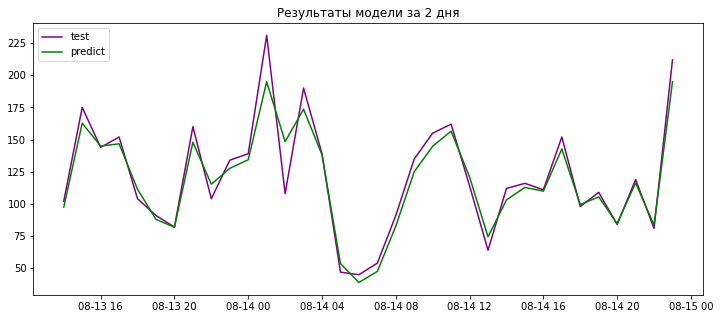

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test['2018-08-13' : '2018-08-14'], 'purple', label='test')
ax.plot(data['2018-08-13' : '2018-08-14'], color='green', label='predict')
ax.legend()
ax.set_title('Результаты модели за 2 дня')
plt.show()